In [1]:
import glob
import torch
import os
import math
import numpy as np
import ast
import PIL

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image

from utils.image_helpers import plot_image_grid
from utils.evaluation_helpers import performance_from_images, average_performances, split_performances

In [2]:
def get_most_recent_gridsearch():
    file_paths = glob.glob("data/gridsearches/*")
    file_paths.sort()
    return file_paths[-1]

In [3]:
running = True

# Load Results

In [4]:
gridsearch_path = get_most_recent_gridsearch()

image_dicts = []

# Get all images

for path in Path(gridsearch_path).rglob('*.png'):
    image = np.array(Image.open(path).convert('L'))[:,:,None]
    image = image.astype(np.float32)/255
    
    relative_path = os.path.relpath(path, gridsearch_path)
    info_list = os.path.splitext(relative_path)[0].split(os.sep)
    
    image_dict = {'image': image, 'type': info_list[0], 'image_index': int(info_list[-1])}
    if len(info_list) > 2:
        image_dict['input shape'] = ast.literal_eval(info_list[1])
        image_dict['layers'] = ast.literal_eval(info_list[2])
        image_dict['channels'] = ast.literal_eval(info_list[3])
    image_dicts.append(image_dict)

# Get Noisy and Target Images

target_image_dicts = sorted([x for x in image_dicts if x['type']=='target'], key=lambda x: x['image_index'])
target_images = [x['image'] for x in target_image_dicts]

noisy_image_dicts = sorted([x for x in image_dicts if x['type']=='noisy'], key=lambda x: x['image_index'])
noisy_images = [x['image'] for x in noisy_image_dicts]

# Filter 

image_dicts = [x for x in image_dicts if x['type'] != 'target']
if running:
    image_dicts = [x for x in image_dicts if x['image_index'] < len(target_images) - 1]
    target_images = target_images[:-1]
    noisy_images = noisy_images[:-1]
    print(len(target_images), 'images completely processed.')

runs = [[x['image'], target_images[x['image_index']], {k:x[k] for k in x if k!='image'}] for x in image_dicts]

print(len(runs), 'image pairs loaded from', gridsearch_path)

19 images completely processed.
532 image pairs loaded from data/gridsearches/2021-01-15-12:07


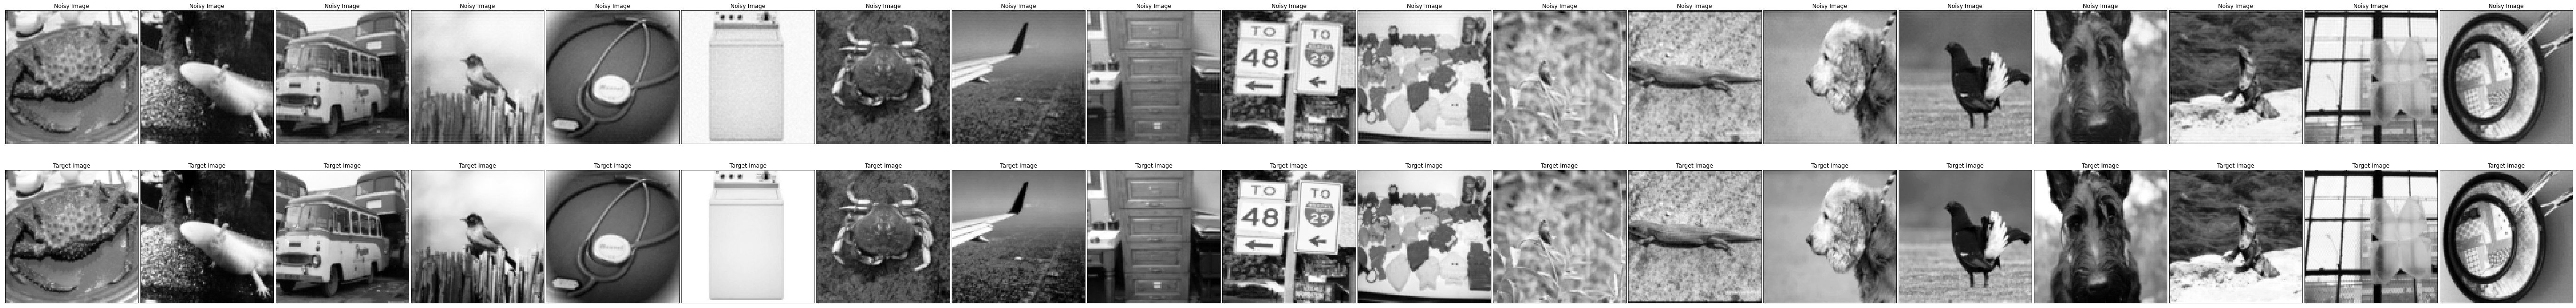

In [5]:
images_to_display = noisy_images + target_images
titles = ['Noisy Image'] * len(noisy_images) + ['Target Image']  * len(target_images)
plot_image_grid(images_to_display, titles, ncols=len(noisy_images))
plt.show()

## Calculate Performances & Average over Images

In [6]:
all_performances = []
for index, run in enumerate(runs):
    print(f'{index+1}/{len(runs)}', end='\r')
    all_performances.append(performance_from_images(*run))
print('')

532/532


In [7]:
noisy_performances = [x for x in all_performances if x['id']['type'] == 'noisy']
noisy_avg_performance = average_performances(noisy_performances, ['image_index'])[0]

model_performances = [x for x in all_performances if x['id']['type'] != 'noisy']
model_avg_performances = average_performances(model_performances, ['image_index'])

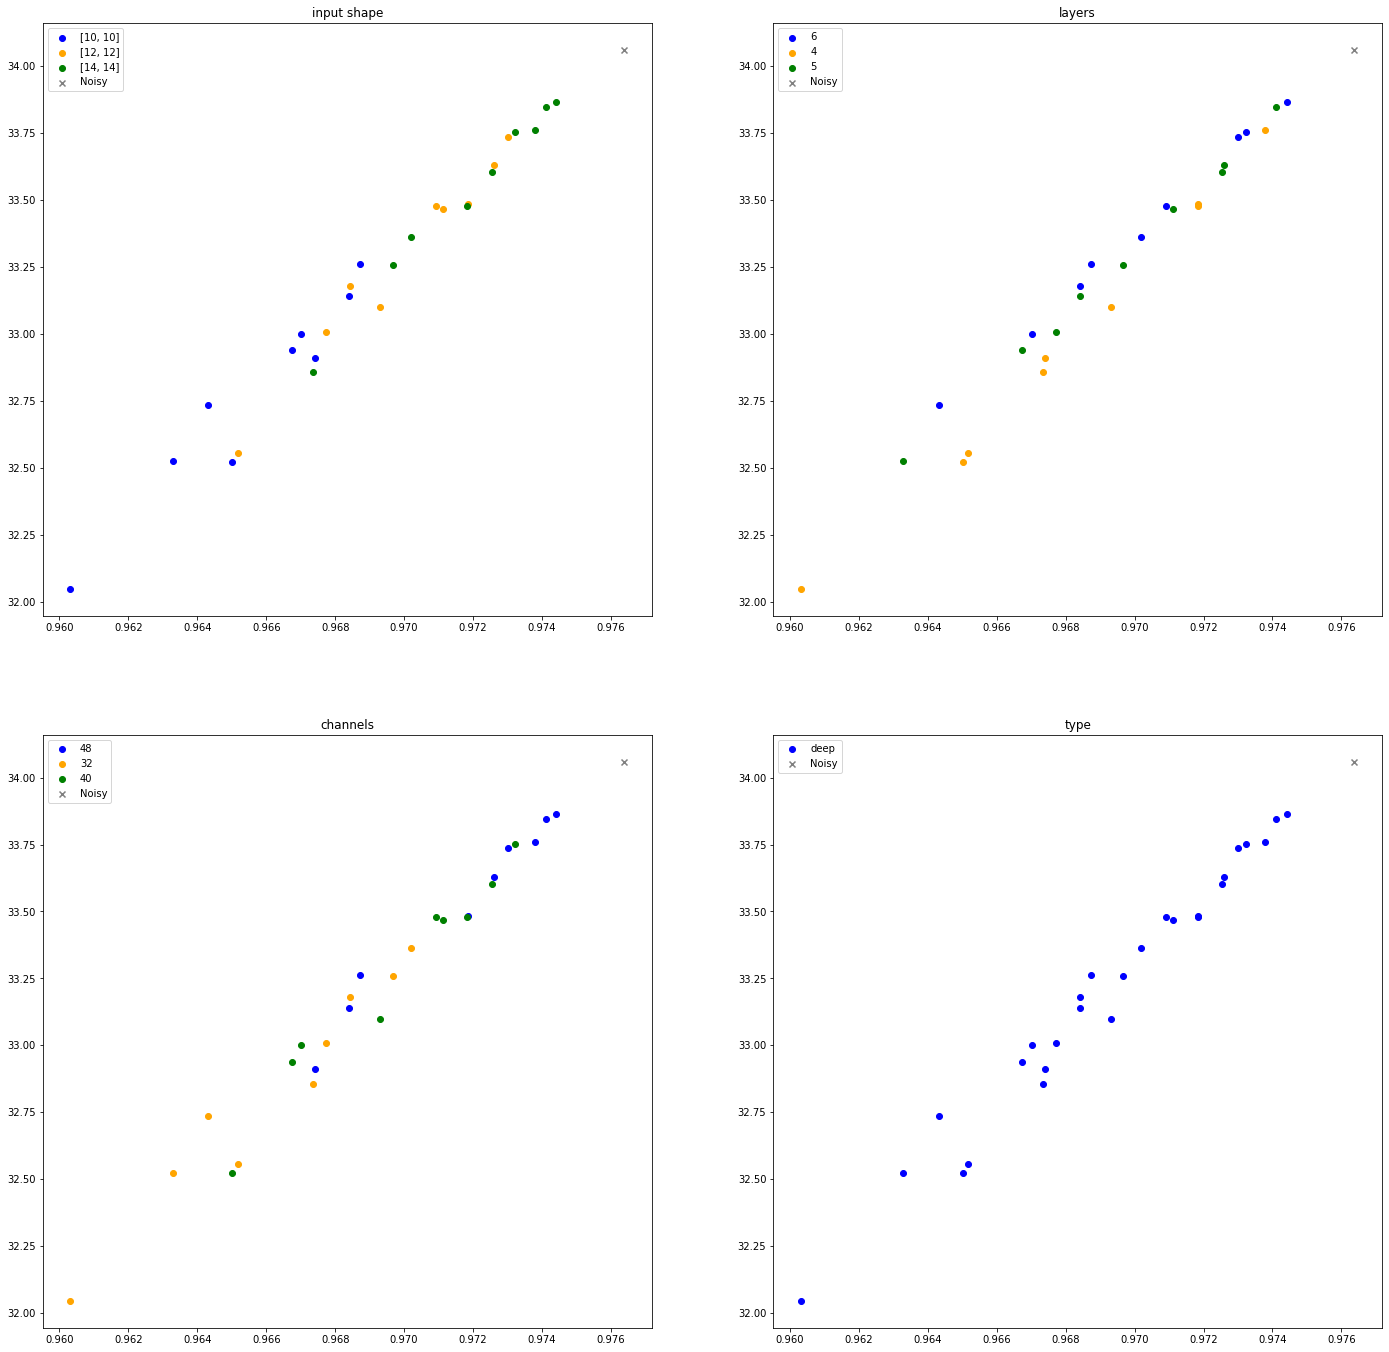

In [8]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
id_keys = ['input shape', 'layers', 'channels', 'type']
figure, axes = plt.subplots(2, 2, figsize=(24,24))

x = 'ssim'
y = 'psnr'


for id_key, axis in zip(id_keys, axes.flatten()):
    splits = split_performances(model_avg_performances, [id_key])
    for index, split in enumerate(splits):
        label = split[0]['id'][id_key]
        x_list = [performance[x] for performance in split]
        y_list = [performance[y] for performance in split]
        axis.scatter(x_list, y_list, c=colors[index], label=label)
    axis.scatter(noisy_avg_performance[x], noisy_avg_performance[y], color='gray', marker='x', label='Noisy')
    axis.set_title(id_key)
    axis.legend()